In [280]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

pairs = [['IEMG', 'EEM'], ['ARKK', 'ARKW'], ['TLT', 'SPTL'], ['SHY', 'VGSH'], ['SOXX', 'ITA']]

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_25055/2370643600.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  10 of 10 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_25055/2370643600.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']
[*********************100%***********************]  10 of 10 completed


In [281]:
def predict_mean_reversion_label(spread, window, threshold):
    labels = []
    mean = spread.mean()

    for i in range(len(spread)):
        future_spread = spread[i + 1 : i + 1 + window]
        if len(future_spread) < window:
            labels.append(np.nan)
        elif any(abs(j - mean) < threshold for j in future_spread):
            labels.append(1)
        else:
            labels.append(0)

    return pd.Series(labels, index = spread.index)

In [282]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def create_features(spread, pair, window):
    df = pd.DataFrame({'spread': spread})

    df['z-score'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()
    df['z-score_lag1'] = df['z-score'].shift(1)
    df['spread_lag1'] = df['spread'].shift(1)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    df['z-score_lag2'] = df['z-score'].shift(2)
    df['z-score_lag5'] = df['z-score'].shift(5)

    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

optimal_window_threshold = {'IEMG_EEM': {'window': 7, 'threshold': 0.03},
                            'ARKK_ARKW': {'window': 10, 'threshold': 0.03},
                            'TLT_SPTL': {'window': 10, 'threshold': 0.03},
                            'SHY_VGSH': {'window': 7, 'threshold': 0.03},
                            'SOXX_ITA': {'window': 30, 'threshold': 0.1}
}

for etf1, etf2 in pairs:

    pair_name = f'{etf1}_{etf2}'

    window = optimal_window_threshold[pair_name]['window']

    threshold = optimal_window_threshold[pair_name]['threshold']

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, pair_name, window = window)
    test_features = create_features(testing_spread, pair_name, window = window)

    train_labels = predict_mean_reversion_label(training_spread, window = window, threshold = threshold)
    train_features['label'] = train_labels.loc[train_features.index]
    train_features = train_features.dropna(subset=['label'])

    test_labels = predict_mean_reversion_label(testing_spread, window = window, threshold = threshold)
    test_features['label'] = test_labels.loc[test_features.index]
    test_features = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name] = test_features.drop(columns=['label'])
    y_test_dict[pair_name] = test_features['label']


training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [283]:
def create_sequences(X, y, window_size):
    X_seq, y_seq  = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X.iloc[i : i + window_size].values)
        y_seq.append(y.iloc[i + window_size])

    return np.array(X_seq), np.array(y_seq)

In [284]:
class ClassificationLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, input_size, dropout = 0.0):
        super(ClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        dropout = dropout if num_layers > 1 else 0.0
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        # out = self.sigmoid(out)
        return out.squeeze()

In [285]:
def train_model(model, train_loader, criterion, optimizer, epochs = 50, device = 'cpu'):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

In [286]:
def evaluate_model(model, pair_name, test_loader, device = 'cpu'):
    model.eval()
    all_preds = []
    all_true = []
    
    optimal_thresholds = {'IEMG_EEM': 0.90,
                          'ARKK_ARKW': 0.50,
                          'TLT_SPTL': 0.50,
                          'SHY_VGSH': 0.80,
                          'SOXX_ITA': 0.3
                          }
    
    threshold = optimal_thresholds[pair_name]

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    y_pred_label = (y_pred > threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    print("Test Accuracy:", accuracy)
    return y_true, y_pred, y_pred_label

In [287]:
def plot_labels(X_df, y_pred_label, pair_name):
    spread = X_df['spread']
    
    aligned_spread = spread[-len(y_pred_label):]
    predicted_points = aligned_spread[y_pred_label == 1]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x=aligned_spread.index, y=aligned_spread.values, label='Spread', color='black')
    sns.scatterplot(x=predicted_points.index, y=predicted_points.values, color='green', label='Predicted Reversion', s=100, marker='o')
    plt.title(f"Predicted Mean Reversions of {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [288]:
def print_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label, labels = [0, 1])
    print("Confusion Matrix:")
    print(cm)

In [289]:
def print_f1(y_true, y_pred_label):
    f1 = f1_score(y_true, y_pred_label)
    print(f"F1 Score: {f1:.4f}")

In [290]:
def run_pair(pair_name, X_train_dict, y_train_dict, X_test_dict, y_test_dict, epochs, device='cpu'):
    
    params = {'IEMG_EEM': {'hidden_size': 30, 'lr': 0.001, 'num_layers': 1, 'window_size': 3, 'batch_size': 32, 'dropout': 0.0},
              'ARKK_ARKW': {'hidden_size': 70, 'lr': 0.0001, 'num_layers': 2, 'window_size': 5, 'batch_size': 128, 'dropout': 0.0},
              'TLT_SPTL': {'hidden_size': 70, 'lr': 0.0005, 'num_layers': 2, 'window_size': 5, 'batch_size': 32, 'dropout': 0.0},
              'SHY_VGSH': {'hidden_size': 30, 'lr': 0.001, 'num_layers': 2, 'window_size': 5, 'batch_size': 32, 'dropout': 0.2},
              'SOXX_ITA': {'hidden_size': 70, 'lr': 0.0005, 'num_layers': 1, 'window_size': 5, 'batch_size': 32, 'dropout': 0.0}
              }
    
    hidden_size = params[pair_name]['hidden_size']
    lr = params[pair_name]['lr']
    num_layers = params[pair_name]['num_layers']
    window_size = params[pair_name]['window_size']
    batch_size = params[pair_name]['batch_size']
    dropout = params[pair_name]['dropout']

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype=torch.float32)
    y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)
    
    X_test = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(-1)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    
    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    print(f"\nTraining model for pair: {pair_name}")
    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)
    
    print(f"\nEvaluating model for pair: {pair_name}")
    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    plot_labels(X_test_df, y_pred_label, pair_name)

    print_confusion_matrix(y_true, y_pred_label)

    print_f1(y_true, y_pred_label)
    
    return model, y_true, y_pred

In [291]:
# grid search

def grid_search(pair_name, params, device = 'cpu'):
    window_size = params['window_size']
    epochs = params['epochs']
    hidden_size = params['hidden_size']
    lr = params['learning_rate']
    num_layers = params['num_layers']
    batch_size = params['batch_size']
    dropout = params['dropout']

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype=torch.float32)
    y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)

    X_test = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(-1)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)

    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    f1 = f1_score(y_true, y_pred_label)

    return f1, model, params

In [292]:
def grid_search_for_pair(pair_name, param_grid, device='cpu'):
    keys, values = zip(*param_grid.items())
    best_f1 = -np.inf
    best_params = None
    best_model = None

    for v in product(*values):
        params = dict(zip(keys, v))
        print(f"Testing params: {params}")
        f1, model, _ = grid_search(pair_name, params, device=device)
        print(f"F1 Score: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_params = params
            best_model = model

    print(f"Best params for {pair_name}: {best_params}")
    print(f"Best F1 score: {best_f1:.4f}")
    return best_model, best_params, best_f1


Training model for pair: IEMG_EEM
Epoch 1/50 - Loss: 0.1606
Epoch 2/50 - Loss: 0.1522
Epoch 3/50 - Loss: 0.1434
Epoch 4/50 - Loss: 0.1317
Epoch 5/50 - Loss: 0.1186
Epoch 6/50 - Loss: 0.1076
Epoch 7/50 - Loss: 0.1000
Epoch 8/50 - Loss: 0.0953
Epoch 9/50 - Loss: 0.0923
Epoch 10/50 - Loss: 0.0903
Epoch 11/50 - Loss: 0.0889
Epoch 12/50 - Loss: 0.0878
Epoch 13/50 - Loss: 0.0869
Epoch 14/50 - Loss: 0.0861
Epoch 15/50 - Loss: 0.0855
Epoch 16/50 - Loss: 0.0849
Epoch 17/50 - Loss: 0.0843
Epoch 18/50 - Loss: 0.0838
Epoch 19/50 - Loss: 0.0832
Epoch 20/50 - Loss: 0.0827
Epoch 21/50 - Loss: 0.0822
Epoch 22/50 - Loss: 0.0817
Epoch 23/50 - Loss: 0.0812
Epoch 24/50 - Loss: 0.0807
Epoch 25/50 - Loss: 0.0802
Epoch 26/50 - Loss: 0.0797
Epoch 27/50 - Loss: 0.0792
Epoch 28/50 - Loss: 0.0787
Epoch 29/50 - Loss: 0.0782
Epoch 30/50 - Loss: 0.0778
Epoch 31/50 - Loss: 0.0773
Epoch 32/50 - Loss: 0.0768
Epoch 33/50 - Loss: 0.0763
Epoch 34/50 - Loss: 0.0758
Epoch 35/50 - Loss: 0.0754
Epoch 36/50 - Loss: 0.0749
Ep

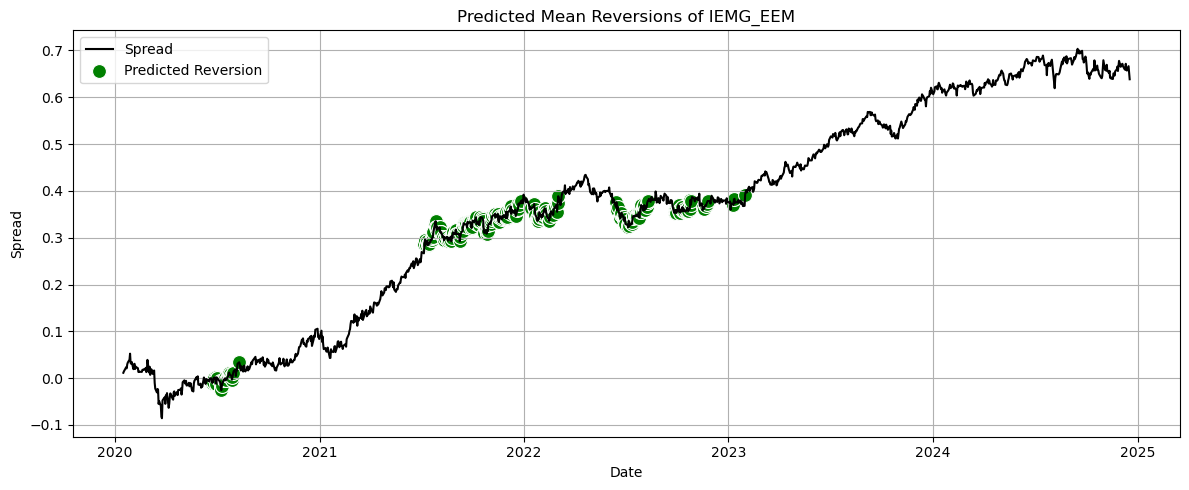

Confusion Matrix:
[[868  60]
 [116 196]]
F1 Score: 0.6901

Training model for pair: ARKK_ARKW
Epoch 1/50 - Loss: 0.5959
Epoch 2/50 - Loss: 0.5953
Epoch 3/50 - Loss: 0.5949
Epoch 4/50 - Loss: 0.5945
Epoch 5/50 - Loss: 0.5941
Epoch 6/50 - Loss: 0.5937
Epoch 7/50 - Loss: 0.5933
Epoch 8/50 - Loss: 0.5930
Epoch 9/50 - Loss: 0.5926
Epoch 10/50 - Loss: 0.5922
Epoch 11/50 - Loss: 0.5918
Epoch 12/50 - Loss: 0.5914
Epoch 13/50 - Loss: 0.5909
Epoch 14/50 - Loss: 0.5905
Epoch 15/50 - Loss: 0.5900
Epoch 16/50 - Loss: 0.5896
Epoch 17/50 - Loss: 0.5891
Epoch 18/50 - Loss: 0.5886
Epoch 19/50 - Loss: 0.5880
Epoch 20/50 - Loss: 0.5875
Epoch 21/50 - Loss: 0.5869
Epoch 22/50 - Loss: 0.5863
Epoch 23/50 - Loss: 0.5856
Epoch 24/50 - Loss: 0.5849
Epoch 25/50 - Loss: 0.5842
Epoch 26/50 - Loss: 0.5835
Epoch 27/50 - Loss: 0.5827
Epoch 28/50 - Loss: 0.5818
Epoch 29/50 - Loss: 0.5809
Epoch 30/50 - Loss: 0.5800
Epoch 31/50 - Loss: 0.5790
Epoch 32/50 - Loss: 0.5779
Epoch 33/50 - Loss: 0.5768
Epoch 34/50 - Loss: 0.57

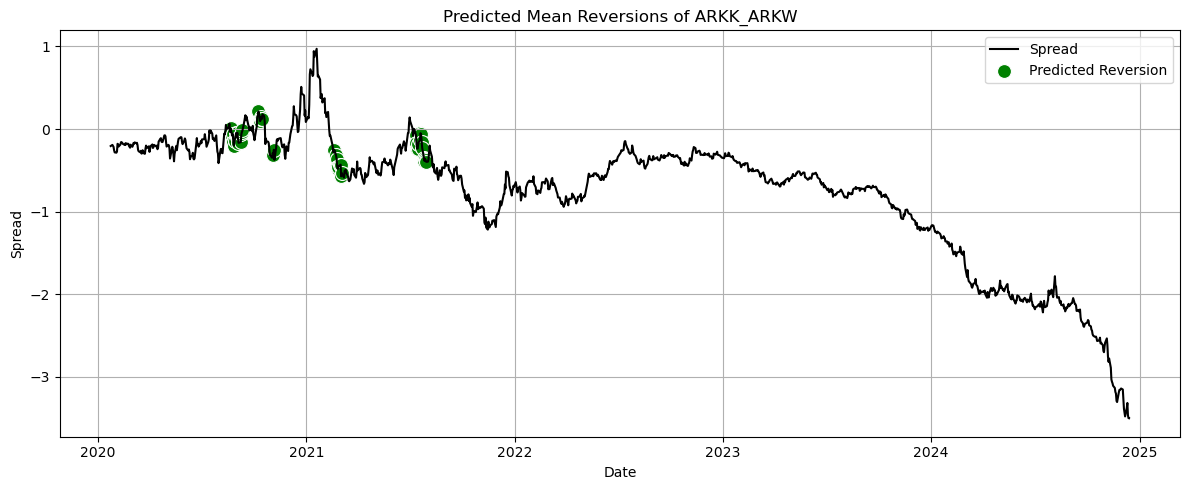

Confusion Matrix:
[[1018   48]
 [ 166    0]]
F1 Score: 0.0000

Training model for pair: TLT_SPTL
Epoch 1/50 - Loss: 0.0293
Epoch 2/50 - Loss: 0.0274
Epoch 3/50 - Loss: 0.0240
Epoch 4/50 - Loss: 0.0216
Epoch 5/50 - Loss: 0.0194
Epoch 6/50 - Loss: 0.0174
Epoch 7/50 - Loss: 0.0160
Epoch 8/50 - Loss: 0.0153
Epoch 9/50 - Loss: 0.0147
Epoch 10/50 - Loss: 0.0141
Epoch 11/50 - Loss: 0.0135
Epoch 12/50 - Loss: 0.0128
Epoch 13/50 - Loss: 0.0123
Epoch 14/50 - Loss: 0.0117
Epoch 15/50 - Loss: 0.0114
Epoch 16/50 - Loss: 0.0109
Epoch 17/50 - Loss: 0.0111
Epoch 18/50 - Loss: 0.0102
Epoch 19/50 - Loss: 0.0144
Epoch 20/50 - Loss: 0.0132
Epoch 21/50 - Loss: 0.0115
Epoch 22/50 - Loss: 0.0105
Epoch 23/50 - Loss: 0.0099
Epoch 24/50 - Loss: 0.0096
Epoch 25/50 - Loss: 0.0098
Epoch 26/50 - Loss: 0.0093
Epoch 27/50 - Loss: 0.0096
Epoch 28/50 - Loss: 0.0093
Epoch 29/50 - Loss: 0.0087
Epoch 30/50 - Loss: 0.0110
Epoch 31/50 - Loss: 0.0101
Epoch 32/50 - Loss: 0.0093
Epoch 33/50 - Loss: 0.0086
Epoch 34/50 - Loss: 0

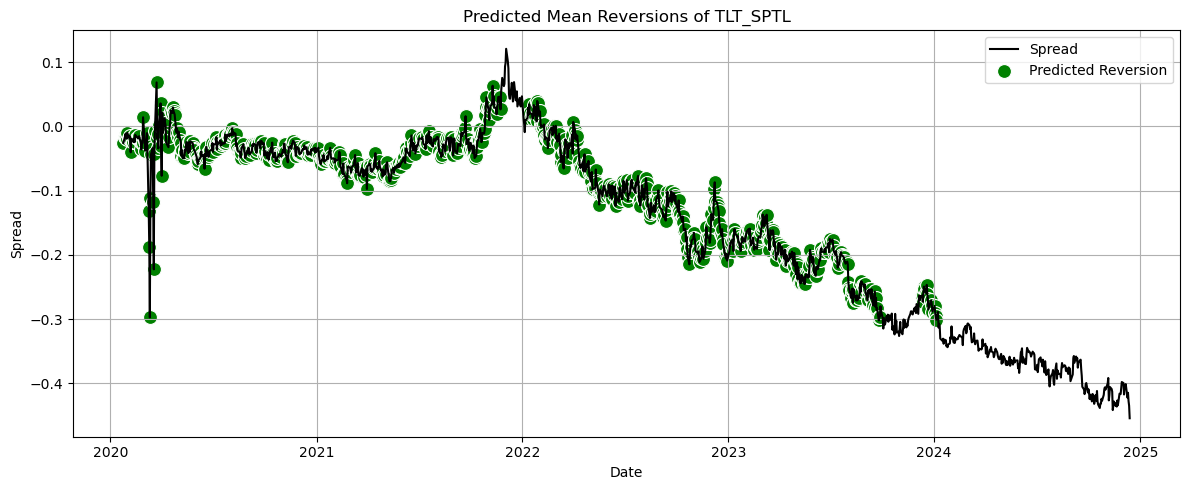

Confusion Matrix:
[[319 702]
 [  0 211]]
F1 Score: 0.3754

Training model for pair: SHY_VGSH
Epoch 1/50 - Loss: 0.0683
Epoch 2/50 - Loss: 0.0605
Epoch 3/50 - Loss: 0.0506
Epoch 4/50 - Loss: 0.0459
Epoch 5/50 - Loss: 0.0432
Epoch 6/50 - Loss: 0.0418
Epoch 7/50 - Loss: 0.0403
Epoch 8/50 - Loss: 0.0400
Epoch 9/50 - Loss: 0.0391
Epoch 10/50 - Loss: 0.0399
Epoch 11/50 - Loss: 0.0404
Epoch 12/50 - Loss: 0.0377
Epoch 13/50 - Loss: 0.0369
Epoch 14/50 - Loss: 0.0365
Epoch 15/50 - Loss: 0.0367
Epoch 16/50 - Loss: 0.0362
Epoch 17/50 - Loss: 0.0375
Epoch 18/50 - Loss: 0.0379
Epoch 19/50 - Loss: 0.0360
Epoch 20/50 - Loss: 0.0350
Epoch 21/50 - Loss: 0.0349
Epoch 22/50 - Loss: 0.0344
Epoch 23/50 - Loss: 0.0355
Epoch 24/50 - Loss: 0.0367
Epoch 25/50 - Loss: 0.0364
Epoch 26/50 - Loss: 0.0343
Epoch 27/50 - Loss: 0.0346
Epoch 28/50 - Loss: 0.0352
Epoch 29/50 - Loss: 0.0337
Epoch 30/50 - Loss: 0.0330
Epoch 31/50 - Loss: 0.0328
Epoch 32/50 - Loss: 0.0326
Epoch 33/50 - Loss: 0.0364
Epoch 34/50 - Loss: 0.038

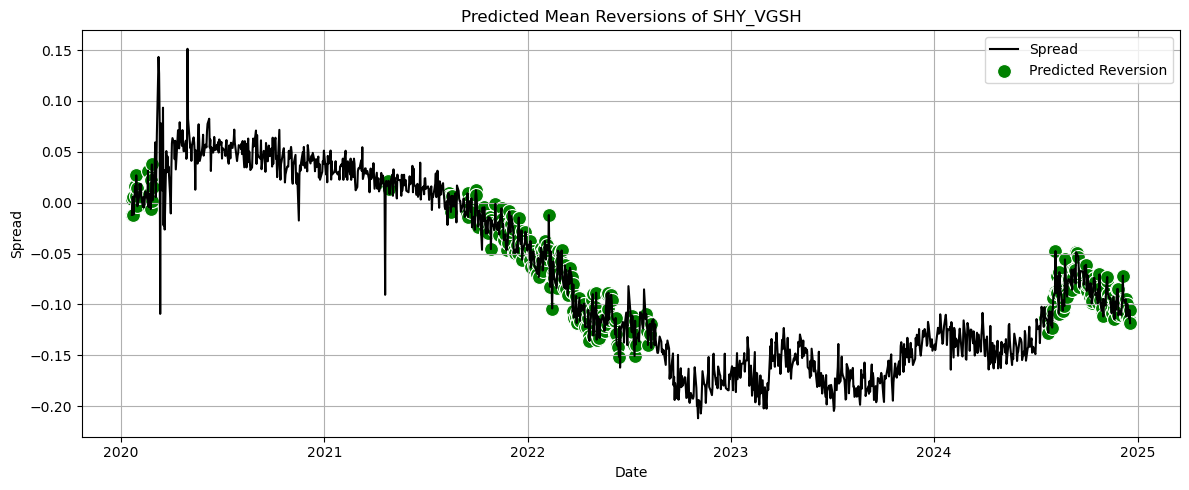

Confusion Matrix:
[[885  86]
 [ 26 241]]
F1 Score: 0.8114

Training model for pair: SOXX_ITA
Epoch 1/50 - Loss: 0.1070
Epoch 2/50 - Loss: 0.0985
Epoch 3/50 - Loss: 0.0948
Epoch 4/50 - Loss: 0.0913
Epoch 5/50 - Loss: 0.0875
Epoch 6/50 - Loss: 0.0833
Epoch 7/50 - Loss: 0.0787
Epoch 8/50 - Loss: 0.0739
Epoch 9/50 - Loss: 0.0692
Epoch 10/50 - Loss: 0.0645
Epoch 11/50 - Loss: 0.0600
Epoch 12/50 - Loss: 0.0559
Epoch 13/50 - Loss: 0.0524
Epoch 14/50 - Loss: 0.0497
Epoch 15/50 - Loss: 0.0476
Epoch 16/50 - Loss: 0.0460
Epoch 17/50 - Loss: 0.0448
Epoch 18/50 - Loss: 0.0438
Epoch 19/50 - Loss: 0.0430
Epoch 20/50 - Loss: 0.0423
Epoch 21/50 - Loss: 0.0417
Epoch 22/50 - Loss: 0.0411
Epoch 23/50 - Loss: 0.0406
Epoch 24/50 - Loss: 0.0402
Epoch 25/50 - Loss: 0.0398
Epoch 26/50 - Loss: 0.0394
Epoch 27/50 - Loss: 0.0390
Epoch 28/50 - Loss: 0.0387
Epoch 29/50 - Loss: 0.0383
Epoch 30/50 - Loss: 0.0380
Epoch 31/50 - Loss: 0.0377
Epoch 32/50 - Loss: 0.0374
Epoch 33/50 - Loss: 0.0371
Epoch 34/50 - Loss: 0.036

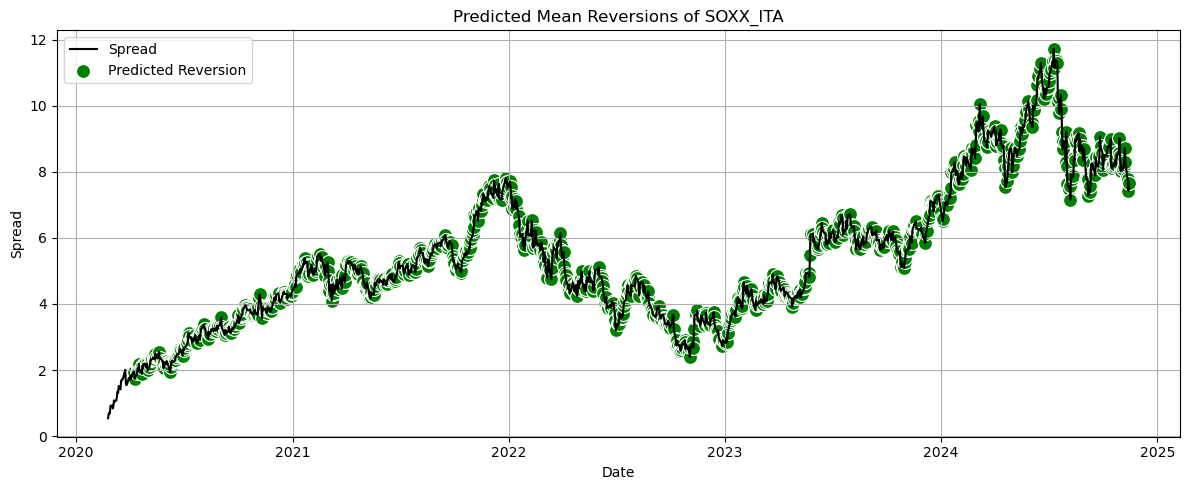

Confusion Matrix:
[[ 32 883]
 [  0 277]]
F1 Score: 0.3855
{'IEMG_EEM': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=1, bias=True)
), 'y_true': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(1240, 1), dtype=float32), 'y_pred': array([0.45370597, 0.45179325, 0.433776  , ..., 0.22011507, 0.22176053,
       0.2235295 ], shape=(1240,), dtype=float32)}, 'ARKK_ARKW': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_layers=2, batch_first=True)
  (linear): Linear(in_features=70, out_features=1, bias=True)
), 'y_true': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(1232, 1), dtype=float32), 'y_pred': array([0.45577946, 0.4569828 , 0.45851716, ..., 0.25820845, 0.25766075,
       0.2572162 ], shape=(1232,), dtype=float32)}, 'TLT_SPTL': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_layers=2, batch_first=True)


In [293]:
results = {}

# param_grid = {
#     'hidden_size': [30, 70],
#     'learning_rate': [0.001, 0.0005, 0.0001],
#     'window_size': [3, 5, 7],
#     'epochs': [50],
#     'num_layers': [1, 2],
#     'batch_size': [32, 64, 128],
#     'dropout': [0.0, 0.2]
# }

# best_params_all = {}
# best_f1_all = {}

# for pair_name in training_spreads_df.columns:
#     print(f"\nStarting grid search for {pair_name}")
#     model, params, f1 = grid_search_for_pair(pair_name, param_grid, device='cpu')
#     results[pair_name] = {'model': model}
#     best_params_all[pair_name] = params
#     best_f1_all[pair_name] = f1

for pair_name in training_spreads_df.columns:
    model, y_true, y_pred = run_pair(
        pair_name,
        X_train_dict,
        y_train_dict,
        X_test_dict,
        y_test_dict,
        epochs = 50,
        device = 'cpu'
    )
    results[pair_name] = {'model': model, 'y_true': y_true, 'y_pred': y_pred}

    # window_sizes = [3, 5, 7, 10]
    # thresholds = [0.001, 0.003, 0.005, 0.01, 0.02, 0.03]

    # for window in window_sizes:
    #     for thresh in thresholds:
    #         labels = predict_mean_reversion_label(training_spreads_df[pair_name], window, thresh)
    #         print(f"{pair_name} | Window: {window}, Thresh: {thresh} -> 1s: {labels.sum()}, 0s: {(labels==0).sum()}")

print(results)

In [294]:
def build_prices(pair_list, testing_data, X_test_dict):
    test_prices_dict = {}

    for pair in pair_list:
        etf1, etf2 = pair.split('_')

        price_df = testing_data[[etf1, etf2]].copy()
        price_df.columns = ['price_long', 'price_short']

        test_index = X_test_dict[pair].index
        aligned_prices = price_df.loc[test_index]

        test_prices_dict[pair] = aligned_prices

    return test_prices_dict

In [295]:
def compute_max_drawdown(equity_curve):
    # Compute running max
    running_max = equity_curve.cummax()
    
    # Compute drawdowns
    drawdowns = equity_curve / running_max - 1.0

    # Max drawdown
    max_drawdown = drawdowns.min()
    
    return max_drawdown, drawdowns

In [296]:
def plot_combined_equity_and_drawdown(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax[0].plot(equity, label='Combined Equity')
    ax[0].set_title("Combined Equity Curve")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(drawdown, color='red', label='Drawdown')
    ax[1].set_title("Drawdown Over Time")
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()


In [297]:
def simulate_portfolio(
    X_df, probs, y_pred_label, prices_df,
    initial_cash_per_pair = 100.0,
    holding_period = 5,
    entry_threshold = 1,
):
    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    df['prob'] = probs
    df['label'] = y_pred_label
    df = df.join(prices_df)

    cash = initial_cash_per_pair
    equity = pd.Series(index = df.index, dtype = float)
    equity.iloc[0] = cash
    trades = []

    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        prob = row['prob']
        zscore = row['z-score']
        price_long_in = row['price_long']
        price_short_in = row['price_short']

        if (prob > 0.5 and abs(zscore) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price_long_out = df.iloc[exit_idx]['price_long']
            price_short_out = df.iloc[exit_idx]['price_short']

            notional = initial_cash_per_pair
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if zscore > 0:
                shares_short_long = short_dollars / price_long_in
                shares_long_short = long_dollars / price_short_in

                pnl = (shares_long_short * (price_short_out - price_short_in)) + \
                      (shares_short_long * (price_long_in - price_long_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                shares_long_long = long_dollars / price_long_in
                shares_short_short = short_dollars / price_short_in

                pnl = (shares_long_long * (price_long_out - price_long_in)) + \
                      (shares_short_short * (price_short_in - price_short_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[exit_date] = cash

            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "prob": prob,
                "direction": direction,
                "pnl": pnl,
                "notional": notional
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace = True)
    return equity, trades

In [298]:
def run_simulation(results, X_test_dict, testing_data):
    pair_list = list(X_test_dict.keys())
    test_prices_dict = build_prices(pair_list, testing_data, X_test_dict)

    total_cash = 0
    combined_equity = pd.Series(dtype=float)
    pair_trade_counts = {}
    pair_pnls = {}
    pair_sharpes = {}

    plt.figure(figsize=(14, 6))

    for pair_name in pair_list:
        model_info = results[pair_name]
        model = model_info['model']
        y_true = model_info['y_true']
        y_pred = model_info['y_pred']

        probs = torch.sigmoid(torch.tensor(y_pred)).squeeze().numpy()
        y_pred_label = (probs > 0.5).astype(int)

        prices_df = test_prices_dict[pair_name]
        X_test_df = X_test_dict[pair_name]

        equity, trades = simulate_portfolio(X_test_df, probs, y_pred_label, prices_df)

        pair_returns = equity.pct_change().dropna()

        if pair_returns.std() != 0:
            sharpe = (pair_returns.mean() / pair_returns.std()) * np.sqrt(252)
        else:
            sharpe = np.nan

        pair_sharpes[pair_name] = sharpe

        total_cash += equity.iloc[-1]
        pair_trade_counts[pair_name] = len(trades)
        pair_pnls[pair_name] = [t['pnl'] for t in trades]

        if combined_equity.empty:
            combined_equity = equity
        else:
            combined_equity = combined_equity.add(equity, fill_value = 0)

        sns.lineplot(x = equity.index, y = equity.values, label = pair_name)

    plt.title("Equity Curve by Pair")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
    print("\nTrade Summary:")
    for pair, count in pair_trade_counts.items():
        total_pnl = sum(pair_pnls[pair])
        avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
        print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    yearly = combined_equity.resample('YE').last()
    print("\nYear-End Portfolio Values:")
    print(yearly)

    print("\nSharpe Ratios by Pair:")
    for pair, sharpe in pair_sharpes.items():
        print(f"  {pair}: Sharpe Ratio = {sharpe:.2f}")

    combined_returns = combined_equity.pct_change().dropna()
    sharpe_ratio = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
    print(f"\nTotal Sharpe Ratio: {sharpe_ratio:.2f}")

    max_dd, drawdowns = compute_max_drawdown(equity)
    print(f"Max Drawdown: {max_dd:.2%}")

    plot_combined_equity_and_drawdown(equity)

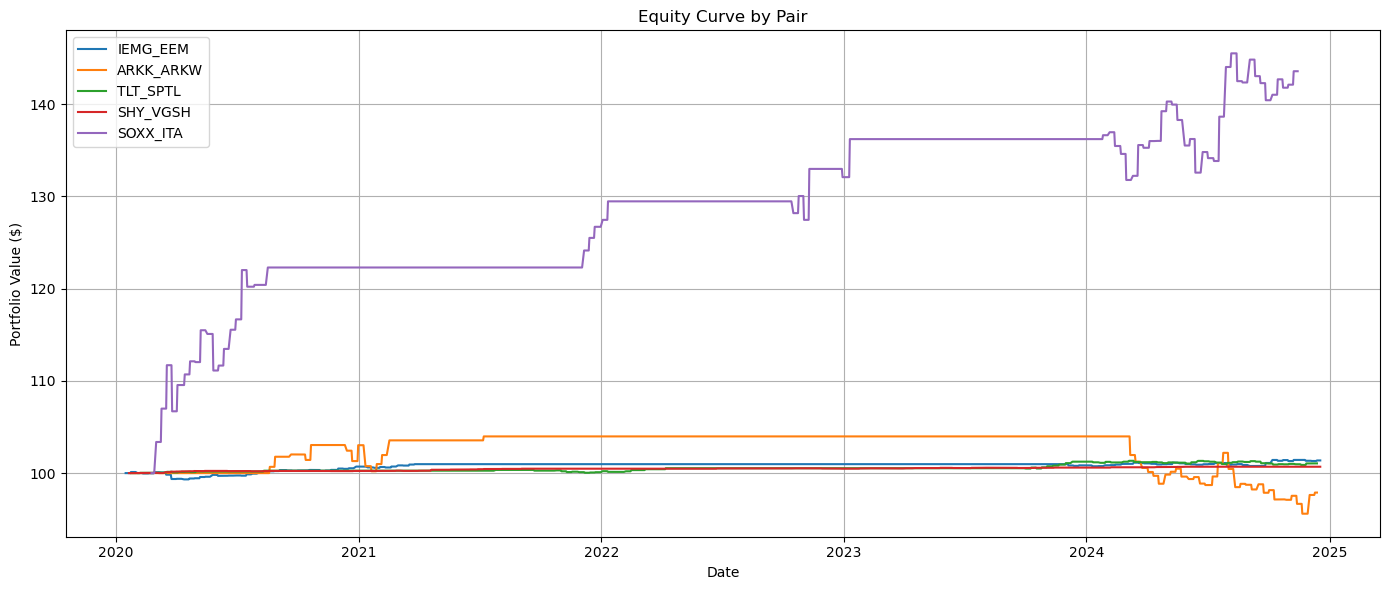


Final Portfolio Value: $544.59

Trade Summary:
  IEMG_EEM: 94 trades | Total PnL: $1.37 | Avg PnL: $0.01
  ARKK_ARKW: 48 trades | Total PnL: $-2.11 | Avg PnL: $-0.04
  TLT_SPTL: 76 trades | Total PnL: $1.05 | Avg PnL: $0.01
  SHY_VGSH: 117 trades | Total PnL: $0.69 | Avg PnL: $0.01
  SOXX_ITA: 64 trades | Total PnL: $43.59 | Avg PnL: $0.68

Year-End Portfolio Values:
Date
2020-12-31    526.526922
2021-12-31    532.237716
2022-12-31    538.058546
2023-12-31    542.880701
2024-12-31    202.063850
Freq: YE-DEC, dtype: float64

Sharpe Ratios by Pair:
  IEMG_EEM: Sharpe Ratio = 0.60
  ARKK_ARKW: Sharpe Ratio = -0.12
  TLT_SPTL: Sharpe Ratio = 0.66
  SHY_VGSH: Sharpe Ratio = 1.59
  SOXX_ITA: Sharpe Ratio = 1.09

Total Sharpe Ratio: 0.46
Max Drawdown: -5.50%


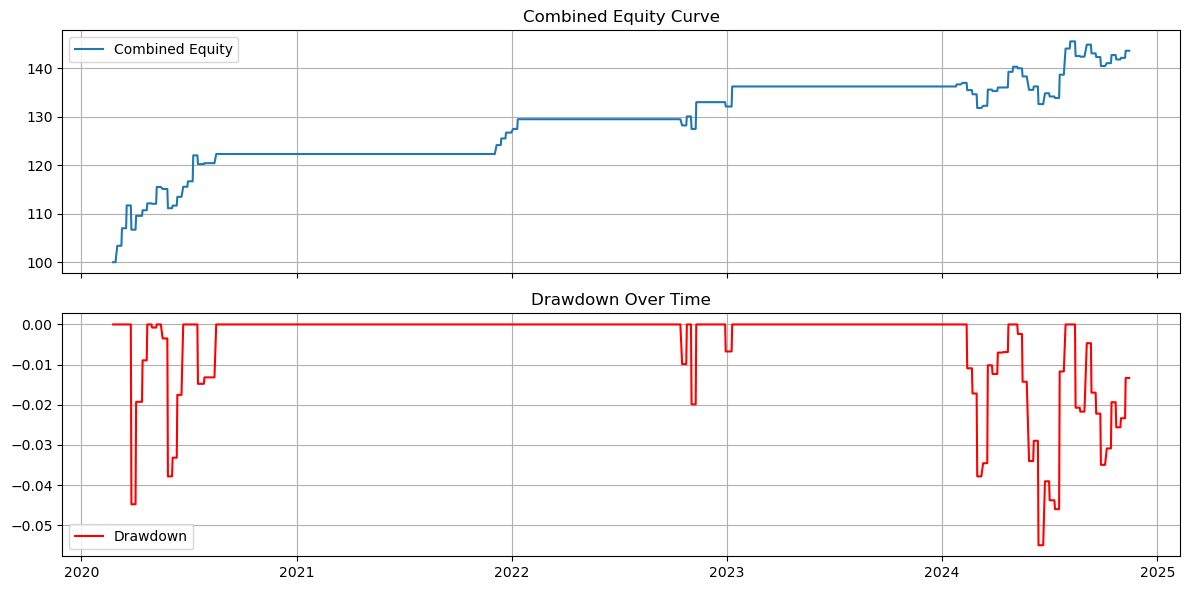

In [299]:
run_simulation(results, X_test_dict, testing_data)